# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [BreakingBall LHP](#Breaking-Ball-LHP)
    - [Off-Speed RHP](#off-Speed-RHP)
    - [Off-Speed LHP](#Off-Speed-LHP)

# Imports

In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705434, 63)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,woba_value,woba_denom,xwoba,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,arm_angle,slot,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,0.0,1.0,0.158,61,4,9,0,5,0,5,0,0,0,0,2,36.0,1,1,0,1,1,0,0,0,0.11,-0.11,0.00,-0.11,-0.271,0.0,1.209,-0.328,0.0,0.222,-0.152,-0.11
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,45.8,2,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.300,-0.053,0.00
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,38.4,1,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.356,-0.038,0.00
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,38.4,1,0,1,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.314,0.028,0.00
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,0.0,1.0,0.090,60,2,9,0,5,0,5,0,0,0,0,1,36.0,1,1,0,1,0,0,0,0,0.29,-0.18,0.11,-0.18,-0.271,0.0,1.209,-0.328,0.0,0.356,-0.038,-0.18


# Cleaning / EDA

### Features

**Independent Variables:** Velocity, Spin Rate, HB, VB, Release Side, Release Height, Arm Angle, Release Extension

**Dependent Variable:** Run Value

In [3]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'pfx_x', 'pfx_z', 
                 'release_extension', 'arm_angle','rv']]

In [4]:
fb = features[features['pitch_type'].isin(['FF', 'FC', 'SI'])]
bb = features[features['pitch_type'].isin(['SL', 'CU', 'KC'])]
os = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fb = fb.loc[fb['p_throws'] == 'R']
lhp_fb = fb.loc[fb['p_throws'] == 'L']
rhp_bb = bb.loc[bb['p_throws'] == 'R']
lhp_bb = bb.loc[bb['p_throws'] == 'L']
rhp_os = os.loc[os['p_throws'] == 'R']
lhp_os = os.loc[os['p_throws'] == 'L']

# Random Forest Regression Model

## Fastball RHP Grouped

#### 4-Seam, Cutter, Sinker

In [5]:
print('Baseline RHP Fastball RunValue Accuracy Score:', round(rhp_fb.rv.mean(), 2))

Baseline RHP Fastball RunValue Accuracy Score: 0.01


In [6]:
features_fb_r = rhp_fb.select_dtypes([np.number])
X = features_fb_r.drop(columns = ['rv'])
y = features_fb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_fb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.066
Test RMSE: 0.263
Test MAE: 0.132 

R2 Score: 0.626
RMSE: 0.156
MAE: 0.07


### RHP Fastball Actual & Predicted Values

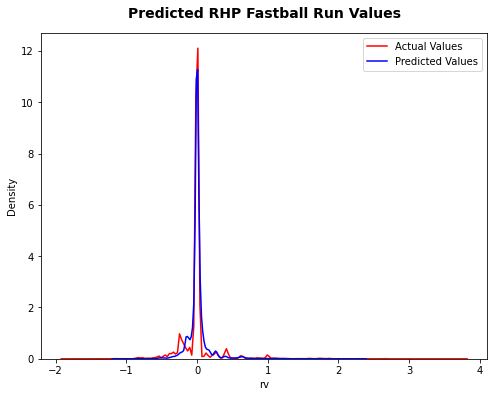

In [7]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Fastball RV Table

Velocity, Spin Rate, HB, VB, Release Side, Release Height, Arm Angle, Release Extension

In [8]:
rhp_fb['FF_count'] = [1 if x == 'FF' else 0 for x in rhp_fb['pitch_type']]
rhp_fb['SI_count'] = [1 if x == 'SI' else 0 for x in rhp_fb['pitch_type']]
rhp_fb['FC_count'] = [1 if x == 'FC' else 0 for x in rhp_fb['pitch_type']]

rhp_fb['xRV'] = pred
grouped_fb_r = rhp_fb.groupby(['player_name', 'pitch_type'], 
                              as_index = False)['FF_count', 'SI_count', 'FC_count', 'velo',
                                                'pfx_x', 'pfx_z', 'release_extension', 
                                                'arm_angle', 'rv', 'xRV'].sum()
grouped_fb_r['RV/100'] = round(((grouped_fb_r['rv'] / (grouped_fb_r['FF_count'] +
                                                       grouped_fb_r['SI_count'] +
                                                       grouped_fb_r['FC_count'])) * 100), 2)
grouped_fb_r['xRV/100'] = round(((grouped_fb_r['xRV'] / (grouped_fb_r['FF_count'] + 
                                                         grouped_fb_r['SI_count'] +
                                                         grouped_fb_r['FC_count'])) * 100), 2)

fb_r_group = pd.merge(rhp_fb, grouped_fb_r, how = 'left', on = ['player_name'])
fb_r_group.head()
fb_drop_cols = ['pitch_type_x', 'FF_count_x', 'SI_count_x', 'FC_count_x', 
                'velo_y', 'pfx_x_y', 'pfx_z_y', 'release_extension_y', 'arm_angle_y']
fb_r_group.drop(columns = fb_drop_cols, inplace = True)
col_dict_fb = {
    'pitch_type_y': 'pitch_type', 'rv_x': 'rv_above_outs', 'xRV_x': 'xrv_above_outs',
    'FF_count_y': 'FF_count', 'SI_count_y': 'SI_count', 'FC_count_y': 'FC_count',
    'velo_x': 'velo', 'pfx_x_x': 'HB', 'pfx_z_x': 'VB', 
    'release_extension_x': 'rel_extension', 'arm_angle_x': 'arm_angle',
    'rv_y': 'RV', 'xRV_y': 'xRV'
}

fb_r_group.rename(columns = col_dict_fb, inplace = True)
fb_r_rv_table = fb_r_group.groupby(['player_name', 'p_throws', 'pitch_type', 
                                    'FF_count', 'SI_count', 'FC_count'], 
                                   as_index = False)['velo', 'HB', 'VB', 'rel_extension',
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
fb_r_rv_table = fb_r_rv_table.round(1)
print(fb_r_rv_table.shape)
fb_r_rv_table.head()

(1115, 15)


,player_name,p_throws,pitch_type,FF_count,SI_count,FC_count,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207,0,0,92.6,9.6,17.2,6.2,43.3,7.9,3.8,4.2,2.0
1,"Abreu, Albert",R,FF,103,0,0,97.9,14.1,14.0,6.5,40.9,0.2,0.2,0.3,0.2
2,"Abreu, Albert",R,SI,0,212,0,97.9,14.1,14.0,6.5,40.9,3.2,1.5,0.5,0.2
3,"Abreu, Bryan",R,FF,310,0,0,95.7,8.0,17.0,6.3,28.7,2.5,0.8,1.3,0.4
4,"Abreu, Bryan",R,SI,0,2,0,95.7,8.0,17.0,6.3,28.7,0.0,0.0,-0.0,-0.6


### RHP Fastball xRV by HB & VB

RHP Fastball Avg xRunValue: 0.01


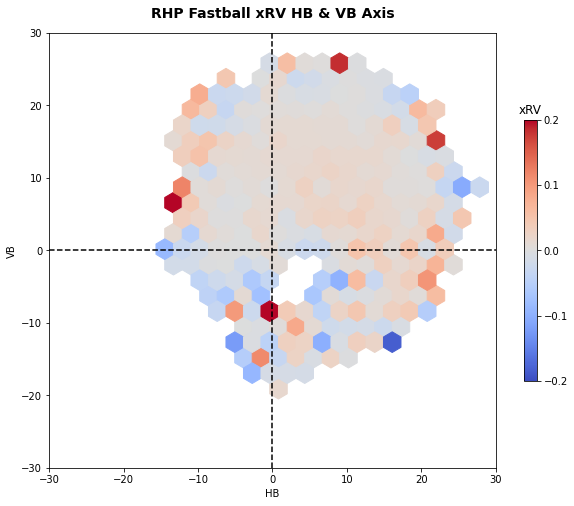

In [10]:
plt.figure(figsize = (10, 8))
plt.hexbin(rhp_fb['pfx_x'], rhp_fb['pfx_z'], C = rhp_fb['xRV'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Fastball Avg xRunValue:', round(rhp_fb.xRV.mean(), 2))

## Fastball LHP Grouped

#### 4-Seam, Cutter, Sinker

In [11]:
print('Baseline LHP Fastball RunValue Accuracy Score:', round(lhp_fb.rv.mean(), 2))

Baseline LHP Fastball RunValue Accuracy Score: 0.01


In [12]:
features_fb_l = lhp_fb.select_dtypes([np.number])
X = features_fb_l.drop(columns = ['rv'])
y = features_fb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_fb_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.078
Test RMSE: 0.258
Test MAE: 0.131 

R2 Score: 0.627
RMSE: 0.154
MAE: 0.07


### LHP Fastball Actual & Predicted Values

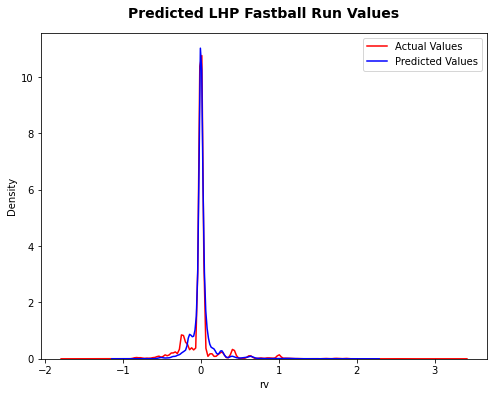

In [13]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball RV Table

In [16]:
lhp_fb['FF_count'] = [1 if x == 'FF' else 0 for x in lhp_fb['pitch_type']]
lhp_fb['SI_count'] = [1 if x == 'SI' else 0 for x in lhp_fb['pitch_type']]
lhp_fb['FC_count'] = [1 if x == 'FC' else 0 for x in lhp_fb['pitch_type']]

lhp_fb['xRV'] = pred
grouped_fb_l = lhp_fb.groupby(['player_name', 'pitch_type'], 
                              as_index = False)['FF_count', 'SI_count', 'FC_count', 'velo',
                                                'pfx_x', 'pfx_z', 'release_extension', 
                                                'arm_angle', 'rv', 'xRV'].sum()
grouped_fb_l['RV/100'] = round(((grouped_fb_l['rv'] / (grouped_fb_l['FF_count'] +
                                                       grouped_fb_l['SI_count'] +
                                                       grouped_fb_l['FC_count'])) * 100), 2)
grouped_fb_l['xRV/100'] = round(((grouped_fb_l['xRV'] / (grouped_fb_l['FF_count'] +
                                                         grouped_fb_l['SI_count'] +
                                                         grouped_fb_l['FC_count'])) * 100), 2)

fb_l_group = pd.merge(lhp_fb, grouped_fb_l, how = 'left', on = ['player_name'])
fb_l_group.drop(columns = fb_drop_cols, inplace = True)
fb_l_group.rename(columns = col_dict_fb, inplace = True)
fb_l_rv_table = fb_l_group.groupby(['player_name', 'p_throws', 'pitch_type', 'FF_count', 
                                    'SI_count', 'FC_count'], 
                                   as_index = False)['velo', 'HB', 'VB', 
                                                     'rel_extension', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
fb_l_rv_table = fb_l_rv_table.round(1)
print(fb_l_rv_table.shape)
fb_l_rv_table.head()

(423, 15)


,player_name,p_throws,pitch_type,FF_count,SI_count,FC_count,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,FC,0,0,16,91.4,-10.9,12.3,5.8,15.3,0.2,1.2,1.0,6.2
1,"Abad, Fernando",L,FF,18,0,0,91.4,-10.9,12.3,5.8,15.3,3.0,16.7,2.5,14.0
2,"Abad, Fernando",L,SI,0,141,0,91.4,-10.9,12.3,5.8,15.3,-1.4,-1.0,1.1,0.8
3,"Aguilar, Miguel",L,FF,62,0,0,91.4,-4.8,15.7,6.0,28.6,-0.4,-0.6,0.4,0.7
4,"Akin, Keegan",L,FF,1009,0,0,92.0,-10.7,18.1,5.9,77.3,-1.9,-0.2,-8.2,-0.8


### LHP Fastball xRV by HB & VB

LHP Fastball Avg xRunValue: 0.01


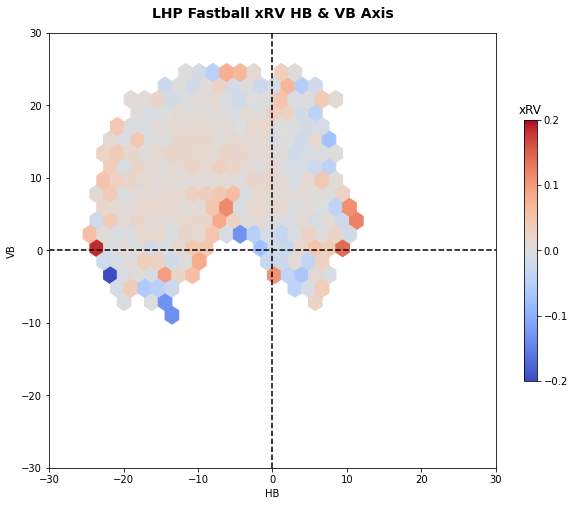

In [18]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_fb['pfx_x'], lhp_fb['pfx_z'], C = lhp_fb['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Fastball Avg xRunValue:', round(lhp_fb.xRV.mean(), 2))

## Breaking Ball RHP

#### Slider, Curveball, Knuckle Curve

In [19]:
print('Baseline RHP Breaking Ball RunValue Accuracy Score:', round(rhp_bb.rv.mean(), 2))

Baseline RHP Breaking Ball RunValue Accuracy Score: -0.01


In [20]:
features_bb_r = rhp_bb.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_bb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.059
Test RMSE: 0.256
MAE: 0.127 

R2 Score: 0.623
Test RMSE: 0.152
MAE: 0.067


### RHP Breaking Ball Actual & Predicted Values

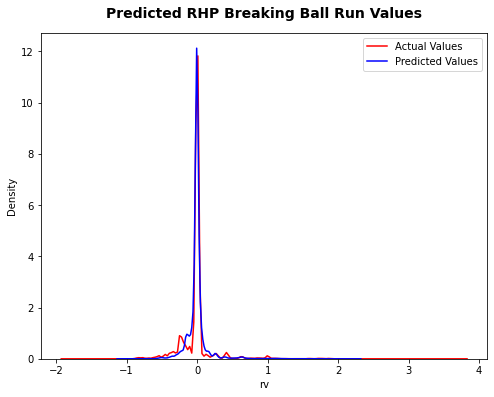

In [21]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Breaking Ball RV Table

In [26]:
rhp_bb['CU_count'] = [1 if x == 'CU' else 0 for x in rhp_bb['pitch_type']]
rhp_bb['SL_count'] = [1 if x == 'SL' else 0 for x in rhp_bb['pitch_type']]
rhp_bb['KC_count'] = [1 if x == 'KC' else 0 for x in rhp_bb['pitch_type']]
rhp_bb['xRV'] = pred
grouped_bb_r = rhp_bb.groupby(['player_name', 'pitch_type'], 
                              as_index = False)['CU_count', 'SL_count', 'KC_count', 'velo',
                                                'pfx_x', 'pfx_z', 'release_extension', 
                                                'arm_angle', 'rv', 'xRV'].sum()
grouped_bb_r['RV/100'] = round(((grouped_bb_r['rv'] / (grouped_bb_r['CU_count'] +
                                                       grouped_bb_r['SL_count'] +
                                                       grouped_bb_r['KC_count'])) * 100), 2)
grouped_bb_r['xRV/100'] = round(((grouped_bb_r['xRV'] / (grouped_bb_r['CU_count'] +
                                                         grouped_bb_r['SL_count'] +
                                                         grouped_bb_r['KC_count'])) * 100), 2)

bb_r_group = pd.merge(rhp_bb, grouped_bb_r, how = 'left', on = ['player_name'])
bb_drop_cols = ['pitch_type_x', 'CU_count_x', 'SL_count_x', 'KC_count_x', 'velo_y', 'pfx_x_y', 
                'pfx_z_y', 'release_extension_y', 'arm_angle_y']
bb_r_group.drop(columns = bb_drop_cols, inplace = True)
col_dict_bb = {
    'pitch_type_y': 'pitch_type', 'rv_x': 'rv_above_outs', 'xRV_x': 'xrv_above_outs',
    'CU_count_y': 'CU_count', 'SL_count_y': 'SL_count', 'KC_count_y': 'KC_count',
    'velo_x': 'velo', 'pfx_x_x': 'HB', 'pfx_z_x': 'VB', 'release_extension_x': 'rel_extension',
    'arm_angle_x': 'arm_angle', 'rv_y': 'RV', 'xRV_y': 'xRV'
}
bb_r_group.rename(columns = col_dict_bb, inplace = True)
bb_r_rv_table = bb_r_group.groupby(['player_name', 'p_throws', 'pitch_type', 'CU_count', 'SL_count', 'KC_count'], 
                                   as_index = False)['velo', 'HB', 'VB', 
                                                     'rel_extension', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
bb_r_rv_table = bb_r_rv_table.round(1)
print(bb_r_rv_table.shape)
bb_r_rv_table.head()

(900, 15)


,player_name,p_throws,pitch_type,CU_count,SL_count,KC_count,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,CU,58,0,0,86.0,0.8,-2.9,5.9,42.4,-3.7,-6.4,-1.5,-2.5
1,"Abbott, Cory",R,SL,0,63,0,86.0,0.8,-2.9,5.9,42.4,2.0,3.2,3.9,6.2
2,"Abreu, Albert",R,CU,1,0,0,87.2,-2.9,3.4,6.3,41.5,0.0,0.0,-0.0,-0.4
3,"Abreu, Albert",R,SL,0,224,0,87.2,-2.9,3.4,6.3,41.5,-3.0,-1.3,-2.6,-1.2
4,"Abreu, Bryan",R,CU,121,0,0,88.2,-4.9,-4.7,6.2,33.0,2.9,2.4,1.2,1.0


### RHP Breaking Ball xRV by HB & VB

RHP Breaking Ball Avg xRunValue: -0.01


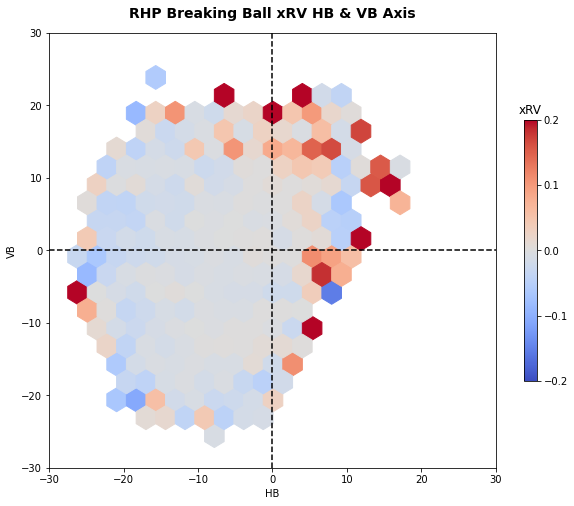

In [27]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_bb['pfx_x'], rhp_bb['pfx_z'], C = rhp_bb['xRV'],cmap='coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Breaking Ball Avg xRunValue:', round(rhp_bb.xRV.mean(), 2))

## Breaking Ball LHP
#### Slider, Curveball, Knuckle Curve

In [28]:
print('Baseline LHP Breaking Ball RunValue Accuracy Score:', round(lhp_bb.rv.mean(), 2))

Baseline LHP Breaking Ball RunValue Accuracy Score: -0.01


In [29]:
features_bb_l = lhp_bb.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['rv'])
y = features_bb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_bb_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.061
Test RMSE: 0.261
Test MAE: 0.127 

R2 Score: 0.616
RMSE: 0.154
MAE: 0.067


### LHP Breaking Ball Actual & Predicted Values

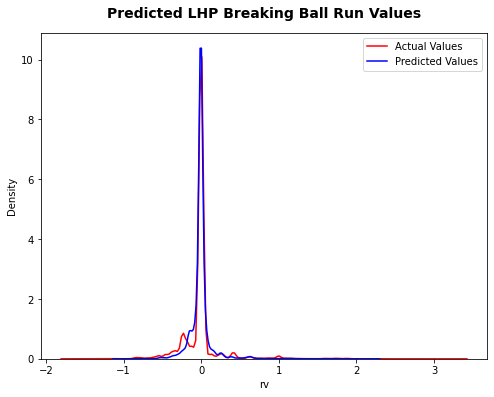

In [30]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball RV Table

In [31]:
lhp_bb['CU_count'] = [1 if x == 'CU' else 0 for x in lhp_bb['pitch_type']]
lhp_bb['SL_count'] = [1 if x == 'SL' else 0 for x in lhp_bb['pitch_type']]
lhp_bb['KC_count'] = [1 if x == 'KC' else 0 for x in lhp_bb['pitch_type']]

lhp_bb['xRV'] = pred
grouped_bb_l = lhp_bb.groupby(['player_name', 'pitch_type'], 
                                         as_index = False)['CU_count', 'SL_count', 'KC_count', 'velo',
                                                           'pfx_x', 'pfx_z', 'release_extension', 
                                                           'arm_angle', 'rv', 'xRV'].sum()
grouped_bb_l['RV/100'] = round(((grouped_bb_l['rv'] / (grouped_bb_l['CU_count'] +
                                                       grouped_bb_l['SL_count'] +
                                                       grouped_bb_l['KC_count'])) * 100), 2)
grouped_bb_l['xRV/100'] = round(((grouped_bb_l['xRV'] / (grouped_bb_l['CU_count'] +
                                                         grouped_bb_l['SL_count'] +
                                                         grouped_bb_l['KC_count'])) * 100), 2)
bb_l_group = pd.merge(lhp_bb, grouped_bb_l, how = 'left', on = ['player_name'])
bb_l_group.drop(columns = bb_drop_cols, inplace = True)
bb_l_group.rename(columns = col_dict_bb, inplace = True)
bb_l_rv_table = bb_l_group.groupby(['player_name', 'p_throws', 'pitch_type', 'CU_count', 'SL_count', 'KC_count'], 
                                   as_index = False)['velo', 'HB', 'VB', 'rel_extension', 'arm_angle', 'RV', 
                                                     'RV/100', 'xRV', 'xRV/100'].mean()
bb_l_rv_table = bb_l_rv_table.round(1)
print(bb_l_rv_table.shape)
bb_l_rv_table.head()

(323, 15)


,player_name,p_throws,pitch_type,CU_count,SL_count,KC_count,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,KC,0,0,78,76.4,7.2,-9.2,5.6,18.8,1.4,1.8,1.1,1.5
1,"Aguilar, Miguel",L,CU,19,0,0,83.2,9.7,5.5,5.9,37.1,-2.3,-12.2,-1.5,-8.0
2,"Aguilar, Miguel",L,SL,0,20,0,83.2,9.7,5.5,5.9,37.1,1.9,9.4,2.7,13.4
3,"Akin, Keegan",L,CU,69,0,0,82.9,4.7,2.0,5.9,84.4,1.1,1.6,1.6,2.3
4,"Akin, Keegan",L,SL,0,344,0,82.9,4.7,2.0,5.9,84.4,9.3,2.7,13.5,3.9


### LHP Breaking Ball xRV by HB & VB

LHP Breaking Ball Avg xRunValue: -0.01


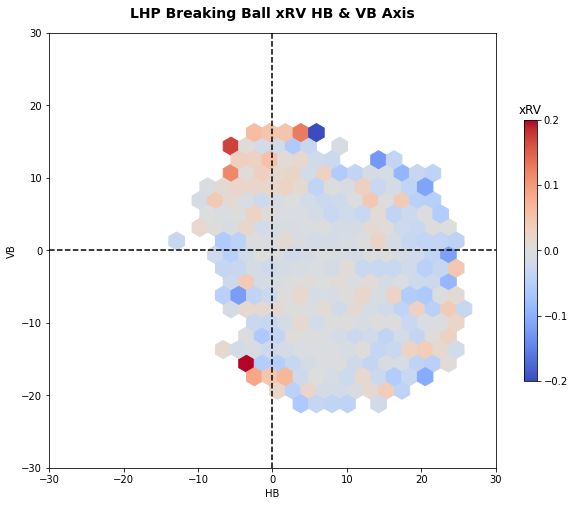

In [32]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_bb['pfx_x'], lhp_bb['pfx_z'], C = lhp_bb['xRV'],cmap='coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Breaking Ball Avg xRunValue:', round(lhp_bb.xRV.mean(), 2))

## Off-Speed RHP

#### Changeup, Splitter

In [33]:
print('Baseline RHP Off-Speed RunValue Accuracy Score:', round(rhp_os.rv.mean(), 2))

Baseline RHP Off-Speed RunValue Accuracy Score: -0.01


In [34]:
features_os_r = rhp_os.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_os_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.065
Test RMSE: 0.262
Test MAE: 0.134 

R2 Score: 0.624
RMSE: 0.156
MAE: 0.071


### RHP Off-Speed Actual & Predicted Run Values

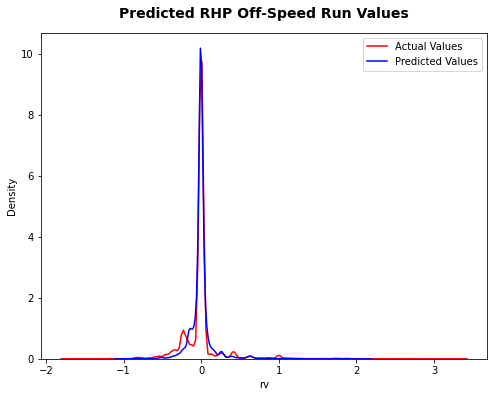

In [35]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Off-Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Off-Speed RV Table

In [36]:
rhp_os['CH_count'] = [1 if x == 'CH' else 0 for x in rhp_os['pitch_type']]
rhp_os['FS_count'] = [1 if x == 'FS' else 0 for x in rhp_os['pitch_type']]

rhp_os['xRV'] = pred
grouped_os_r = rhp_os.groupby(['player_name', 'pitch_type'], 
                                    as_index = False)['CH_count', 'FS_count', 'pfx_x', 'pfx_z',
                                                      'velo', 'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_os_r['RV/100'] = round(((grouped_os_r['rv'] / (grouped_os_r['CH_count'] +
                                                       grouped_os_r['FS_count'])) * 100), 2)
grouped_os_r['xRV/100'] = round(((grouped_os_r['xRV'] / (grouped_os_r['CH_count'] +
                                                         grouped_os_r['FS_count'])) * 100), 2)

os_r_group = pd.merge(rhp_os, grouped_os_r, how = 'left', on = ['player_name'])
os_drop_cols = ['pitch_type_x', 'CH_count_x', 'FS_count_x', 'velo_y', 'pfx_x_y', 'pfx_z_y', 
                'release_extension_y', 'arm_angle_y']
os_r_group.drop(columns = os_drop_cols, inplace = True)
col_dict_os = {
    'pitch_type_y': 'pitch_type', 'rv_x': 'rv_above_outs', 'xRV_x': 'xrv_above_outs',
    'CH_count_y': 'CH_count', 'FS_count_y': 'FS_count', 'velo_x': 'velo',
    'pfx_x_x': 'HB', 'pfx_z_x': 'VB', 'release_extension_x': 'rel_extension',
    'arm_angle_x': 'arm_angle', 'rv_y': 'RV', 'xRV_y': 'xRV'
}
os_r_group.rename(columns = col_dict_os, inplace = True)
os_r_rv_table = os_r_group.groupby(['player_name', 'p_throws', 'pitch_type', 'CH_count', 'FS_count'], 
                                   as_index = False)['velo', 'HB', 'VB', 'rel_extension', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
os_r_rv_table = os_r_rv_table.round(1)
print(os_r_rv_table.shape)
os_r_rv_table.head()

(522, 14)


,player_name,p_throws,pitch_type,CH_count,FS_count,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,CH,23,0,87.0,13.9,12.3,6.1,40.3,-1.0,-4.2,-0.4,-1.5
1,"Abreu, Albert",R,CH,102,0,88.2,16.8,8.6,6.5,38.6,2.5,2.4,-0.5,-0.5
2,"Acevedo, Domingo",R,CH,37,0,86.0,16.9,8.7,6.0,27.8,-1.5,-4.1,-0.7,-2.0
3,"Adam, Jason",R,CH,22,0,87.2,15.8,2.7,6.6,33.1,0.4,1.6,0.4,1.8
4,"Adon, Joan",R,CH,6,0,87.1,16.8,9.3,6.2,43.6,0.0,0.0,-0.0,-0.2


### RHP Off-Speed xRV by HB & VB

RHP Off-Speed Avg xRunValue: -0.0


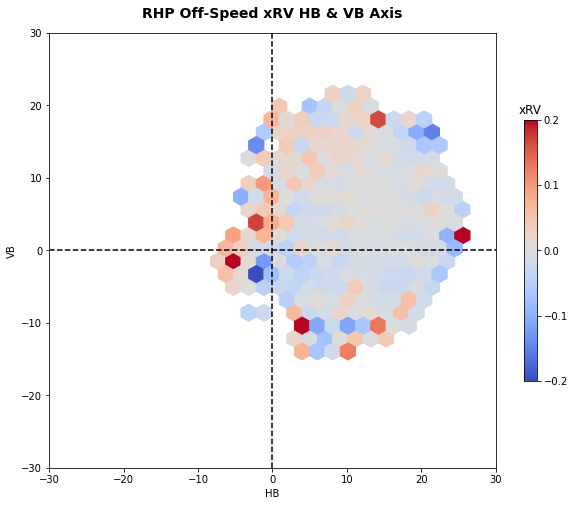

In [38]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off-Speed Avg xRunValue:', round(rhp_os.xRV.mean(), 2))

## Off-speed LHP
#### Changeup, Splitter

In [39]:
print('Baseline LHP Off-Speed RunValue Accuracy Score:', round(lhp_os.rv.mean(), 2))

Baseline LHP Off-Speed RunValue Accuracy Score: -0.0


In [40]:
features_os_l = lhp_os.select_dtypes([np.number])
X = features_os_l.drop(columns = ['rv'])
y = features_os_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_os_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.079
Test RMSE: 0.27
Test MAE: 0.14 

R2 Score: 0.622
RMSE: 0.161
MAE: 0.075


### LHP Off-Speed Actual & Predicted Values

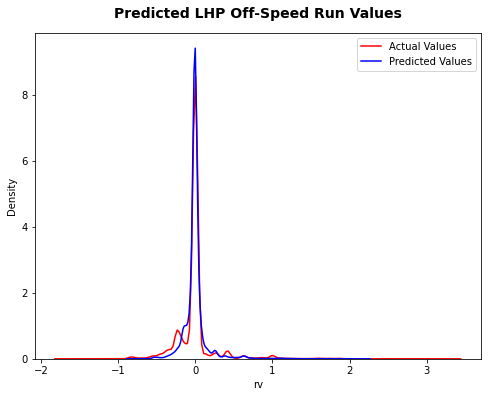

In [41]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Off-Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed RV Table

In [42]:
lhp_os['CH_count'] = [1 if x == 'CH' else 0 for x in lhp_os['pitch_type']]
lhp_os['FS_count'] = [1 if x == 'FS' else 0 for x in lhp_os['pitch_type']]

lhp_os['xRV'] = pred
grouped_os_l = lhp_os.groupby(['player_name', 'pitch_type'], 
                                    as_index = False)['CH_count', 'FS_count', 'velo', 'pfx_x', 'pfx_z', 
                                                      'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_os_l['RV/100'] = round(((grouped_os_l['rv'] / (grouped_os_l['CH_count'] +
                                                       grouped_os_l['FS_count'])) * 100), 2)

grouped_os_l['xRV/100'] = round(((grouped_os_l['xRV'] / (grouped_os_l['CH_count'] +
                                                         grouped_os_l['FS_count'])) * 100), 2)

os_l_group = pd.merge(lhp_os, grouped_os_l, how = 'left', on = ['player_name'])
os_l_group.drop(columns = os_drop_cols, inplace = True)
os_l_group.rename(columns = col_dict_os, inplace = True)
os_l_rv_table = os_l_group.groupby(['player_name', 'p_throws', 'pitch_type', 'CH_count', 'FS_count'], 
                                   as_index = False)['velo', 'HB', 'VB', 'rel_extension', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()

os_l_rv_table = os_l_rv_table.round(1)
print(os_l_rv_table.shape)
os_l_rv_table.head()

(186, 14)


,player_name,p_throws,pitch_type,CH_count,FS_count,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,CH,46,0,75.1,-10.7,14.2,5.9,17.7,-2.4,-5.2,-2.2,-4.7
1,"Aguilar, Miguel",L,CH,3,0,85.8,-14.9,8.9,6.1,31.5,0.0,0.0,0.0,0.8
2,"Akin, Keegan",L,CH,344,0,81.9,-15.3,8.4,6.0,83.2,7.2,2.1,8.0,2.3
3,"Albers, Andrew",L,CH,53,0,80.0,-12.7,7.7,6.1,70.2,-1.2,-2.3,-1.3,-2.4
4,"Alexander, Scott",L,CH,22,0,86.2,-13.6,4.5,6.1,57.0,0.3,1.3,0.2,1.1


### LHP Off-Speed xRV by HB & VB

LHP Off-Speed Avg xRunValue: -0.0


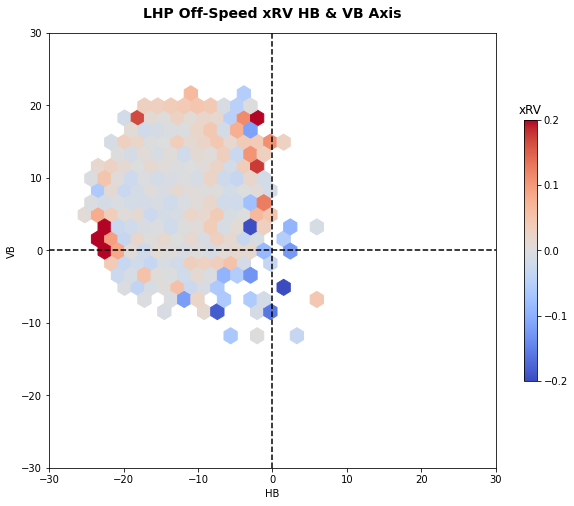

In [43]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_os['pfx_x'], lhp_os['pfx_z'], C = lhp_os['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Off-Speed Avg xRunValue:', round(lhp_os.xRV.mean(), 2))

# Save Grouped RV Tables to CSV

In [54]:
xrv_grouped = pd.concat([rhp_fb, lhp_fb, rhp_bb, lhp_bb, rhp_os, lhp_os], ignore_index = True)
xrv_grouped.fillna(0, inplace = True)
xrv_grouped.to_csv('../data/xrv_grouped.csv')